# Orthogonal Chirps Notebook

## 1. Setup

### a. Includes

These are just the include statements for whatever Python libraries we happen to need.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
import pandas as pd
import sounddevice as sd

import serial
import serial.tools.list_ports
import platform
from datetime import datetime

plt.style.use('dark_background')

### b. Audio Player

The below function / framework is a helper used throughout this notebook for playing sounds. Sound cells will begin with a comment indicating that they play sound, and be separate from other code cells (audio will be their only function). Not all sounds will be audible, as there will be high frequencies outside of the human range of hearing.

In [86]:
adfs = 44.1e3
ad = sd.query_devices()
print(ad)
    
sd.default.samplerate = adfs

def play_audio(arr):
    sd.play(arr)

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (HD Web Camera), MME (2 in, 0 out)
   2 What U Hear (Sound Blaster Reco, MME (2 in, 0 out)
   3 Microphone (Steam Streaming Mic, MME (2 in, 0 out)
   4 Microphone (2- Wireless Stereo , MME (2 in, 0 out)
   5 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  6 DELL U2417H (NVIDIA High Defini, MME (0 in, 2 out)
   7 Speakers (Sound Blaster Recon3D, MME (0 in, 2 out)
   8 Speakers (2- Wireless Stereo He, MME (0 in, 2 out)
   9 Speakers (Steam Streaming Micro, MME (0 in, 2 out)
  10 SPDIF-Out (Sound Blaster Recon3, MME (0 in, 2 out)
  11 Speakers (Steam Streaming Speak, MME (0 in, 2 out)


## 2. Orthogonal Chirps

### a. Parameters

These figures will be modelling those described in the paper "Orthogonal Chirp-Based Ultrasonic Positioning". The parameters listed below are the setup for the equation.

In [91]:
tc =  10e-3       # s
fn =  adfs        # Hz
fs =  15e3        # Hz
fh =  20e3        # Hz
ph =   0          # radians
B = fh - fs       # bandwith NOTE THE CORRECTION
mu = B / tc       # rate
M = 3             # number of transmitters

### b. Sampling Discrete Waveform

Now, it's time to simulate sampling, and we will end up with data similar to the below, assuming we sample at $f_n$.

In [92]:
n = np.arange(0, tc, 1/fn)
print(n.shape)
sn = np.exp(ph) * np.exp(2j * np.pi * ((fs * n) + (0.5 * mu * np.square(n))))

(441,)


If you can't hear the chirp (played via the code below), you're not alone. Try increasing the chirp period (tc), or lowering the frequencies (fs and fh).

In [93]:
# WARNING: SOUND
play_audio(np.imag(sn), block=True)

The code below creates 3 plots of the chirp. The figure on the left shows the first tenth of the chirp (focusing on $f_s$, the starting frequency), the figure in the middle shows the entire chirp, and the figure on the right shows the last tenth of the chirp (focusing on $f_h$, the ending frequency).

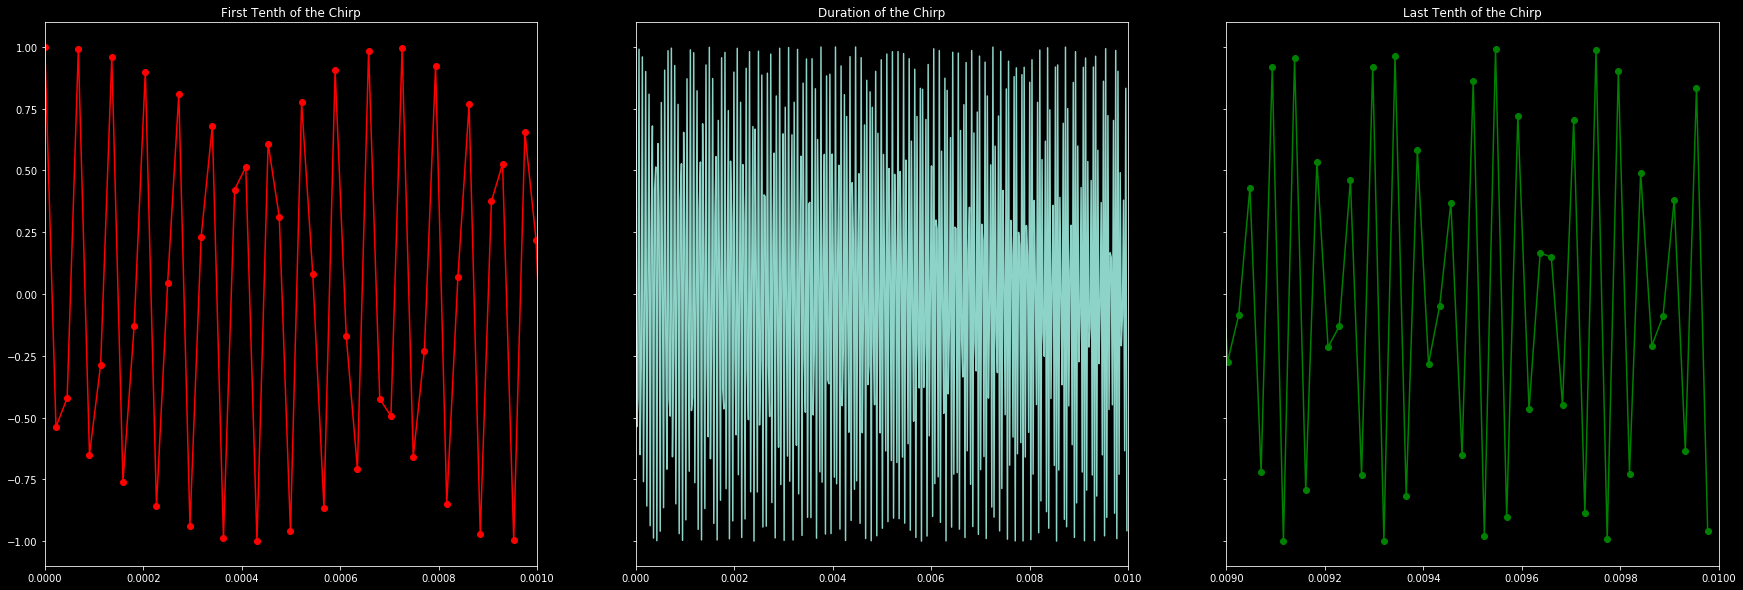

In [94]:
plt.rcParams["figure.figsize"] = (30, 10)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)

ax1.plot(n, np.real(sn), 'ro-')
ax1.set_title("First Tenth of the Chirp")
ax1.set_xlim(0, 0.10 * tc)

ax2.plot(n, np.real(sn))
ax2.set_title("Duration of the Chirp")
ax2.set_xlim(0, tc)

ax3.plot(n, np.real(sn), 'go-')
ax3.set_title("Last Tenth of the Chirp")
ax3.set_xlim(0.90 * tc, tc)

plt.show()

### c. DFT and Zero Padding

Now it's time to perform a DFT on our sampled data, and pad this with zeros, based on M.

In [95]:
Sn = sc.fft.fft(sn, int(fn * tc))  # DFT
Sz = np.zeros(len(Sn)) # zeros for padding

On = () # tuple of orthogonal chirps

Pn = [None] * M # temporary array used for Padding the chirps
for i in range(0, M):
    for j in range(0, M):
        if i == j:
            Pn[j] = Sn
        else:
            Pn[j] = Sz
    On += (np.vstack(Pn).T.flatten(),)
# print(On)

So now we have $M$ different $O_m[n]$ combinations (the result of padding $M-1$ zeros. From here, we can compute the autocorrelation, and crosscorrelation.

In [96]:
On_corrF = [None] * M**2 #correlations, calculated in frequency space, still in Fourier
for i in range(M):
    for j in range(M):
        On_corrF[M*i + j] = On[i] * np.conj(On[j])
ot_corrF = [sc.fft.ifft(F) for F in On_corrF] #correlations, calculated in frequency space, no longer in Fourier

Now that we've done this, we can plot the correlations.

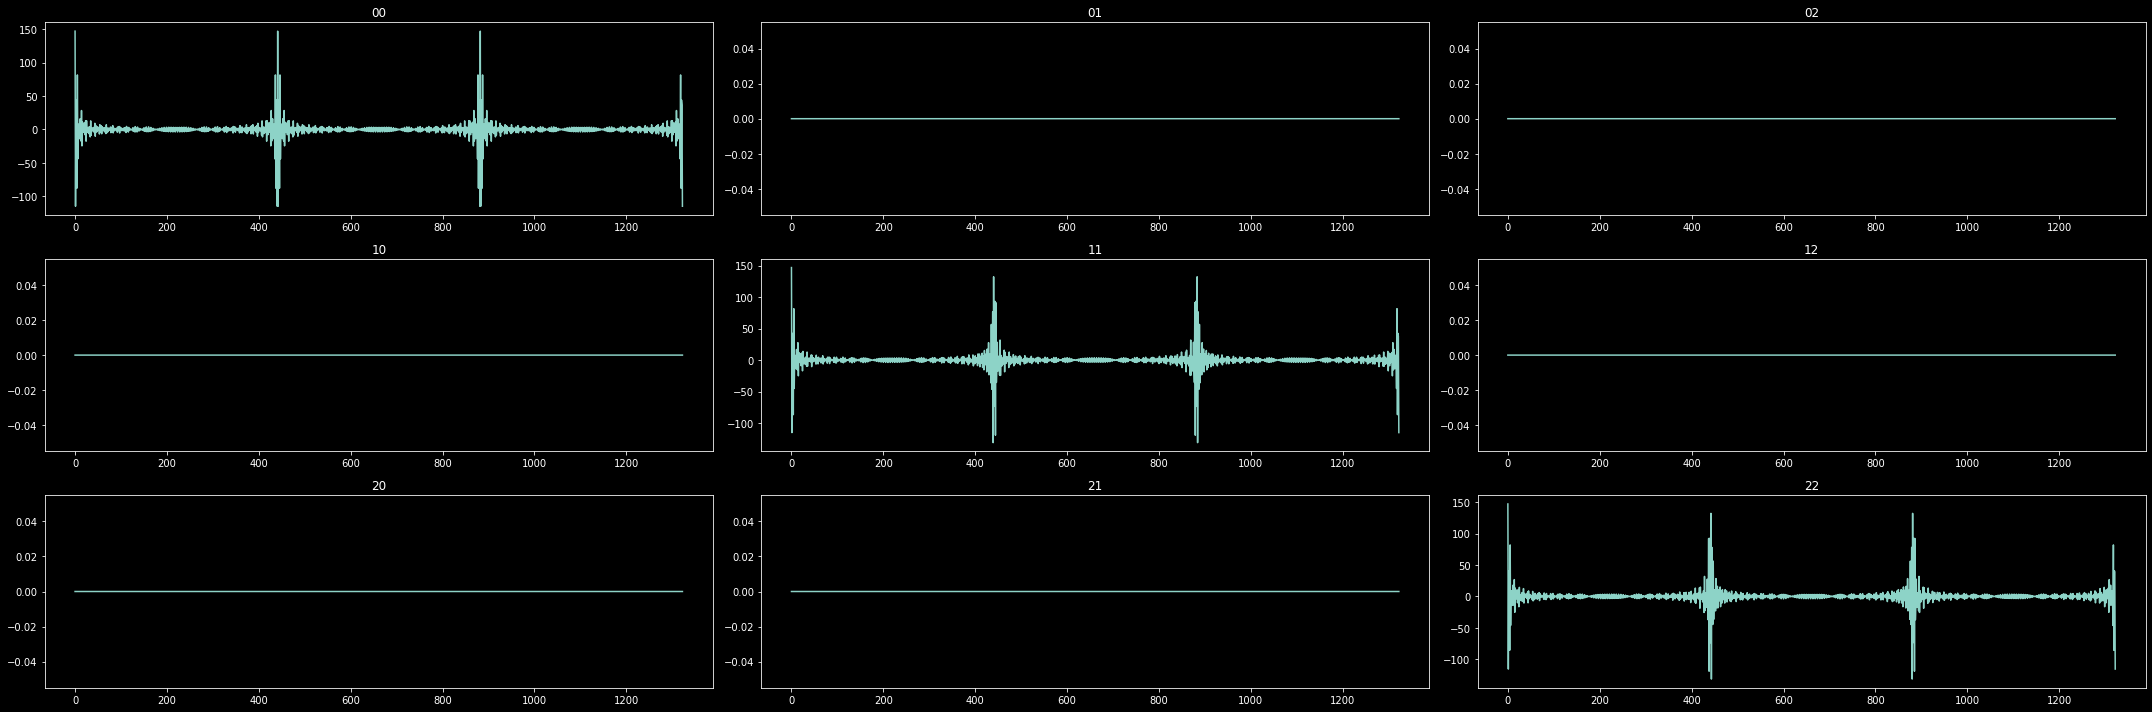

In [97]:
fig, axes = plt.subplots(nrows=M, ncols=M)

for i in range(M):
    for j in range(M):
        axes[i, j].set_title(str(i) + str(j))
        axes[i, j].plot(np.real(ot_corrF[i*M + j]))
plt.tight_layout()
plt.show()

In [98]:
ot = [sc.fft.ifft(O) for O in On] #converting the padding back to time space

ot_corrT = [None] * M**2 #correlations, calculated in frequency space, still in Fourier
for i in range(M):
    for j in range(M):
        ot_corrT[M*i + j] = np.correlate(ot[i], ot[j], mode='full')

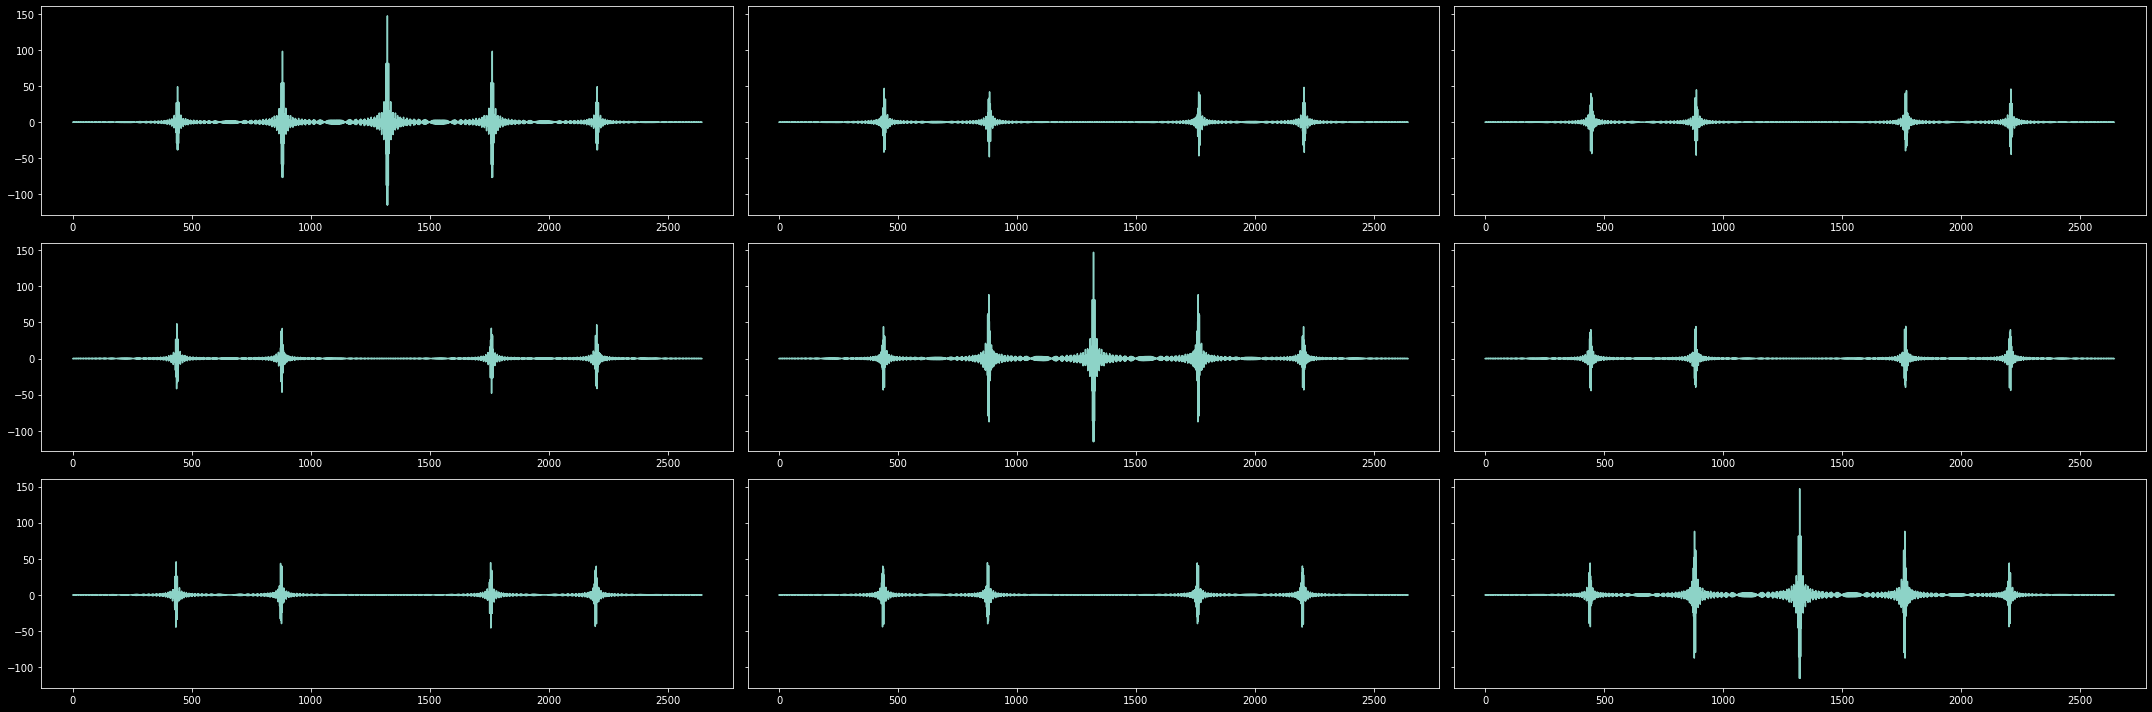

In [99]:
fig, axes = plt.subplots(nrows=M, ncols=M, sharey=True)

for i in range(M):
    for j in range(M):
        axes[i, j].plot(np.real(ot_corrT[i*M + j]))
plt.tight_layout()
plt.show()

## PDM Microphone Data

### a. Setting up Serial Port

We're going to be connecting to a Silicon Labs BG22, flashed with our program (TODO: insert link). We will be using this connection to obtain more data on which to apply concepts from previous parts of the notebook.

In [15]:
def tprint(*args, **kwargs):
    stamp = str(datetime.now())
    print("[" + stamp + "]", *args)
# determine which OS
devOS = platform.system()
tprint("detected", devOS, "device")

# list all serial ports
ports = []
tprint("listing all serial ports:")
if devOS == "Windows":
    ports = serial.tools.list_ports.comports()
for p in ports:
    print(p)
    
while True:
    try:
        port = input("enter port:")
        s = serial.Serial(port)
        break
    except serial.SerialException:
        tprint("invalid serial port, please try again!")
        continue
# 115200 bps, 8 bits, no parity, and 1 stop bit
tprint("setting up", port.upper(), "for reading BG22")
s.baudrate = 115200
s.bytesize = serial.EIGHTBITS
s.parity = serial.PARITY_NONE
s.stopbits = serial.STOPBITS_ONE

[2020-07-16 15:00:36.003410] detected Windows device
[2020-07-16 15:00:36.003410] listing all serial ports:
COM1 - Communications Port (COM1)
COM5 - JLink CDC UART Port (COM5)


enter port: com5


[2020-07-16 15:00:38.133560] setting up COM5 for reading BG22


### b. Synchronous Chirp and Listening

Now that we have our serial port set up, we can use it for a (singleshot) chirp detection. Run the following cell as many times as you want.

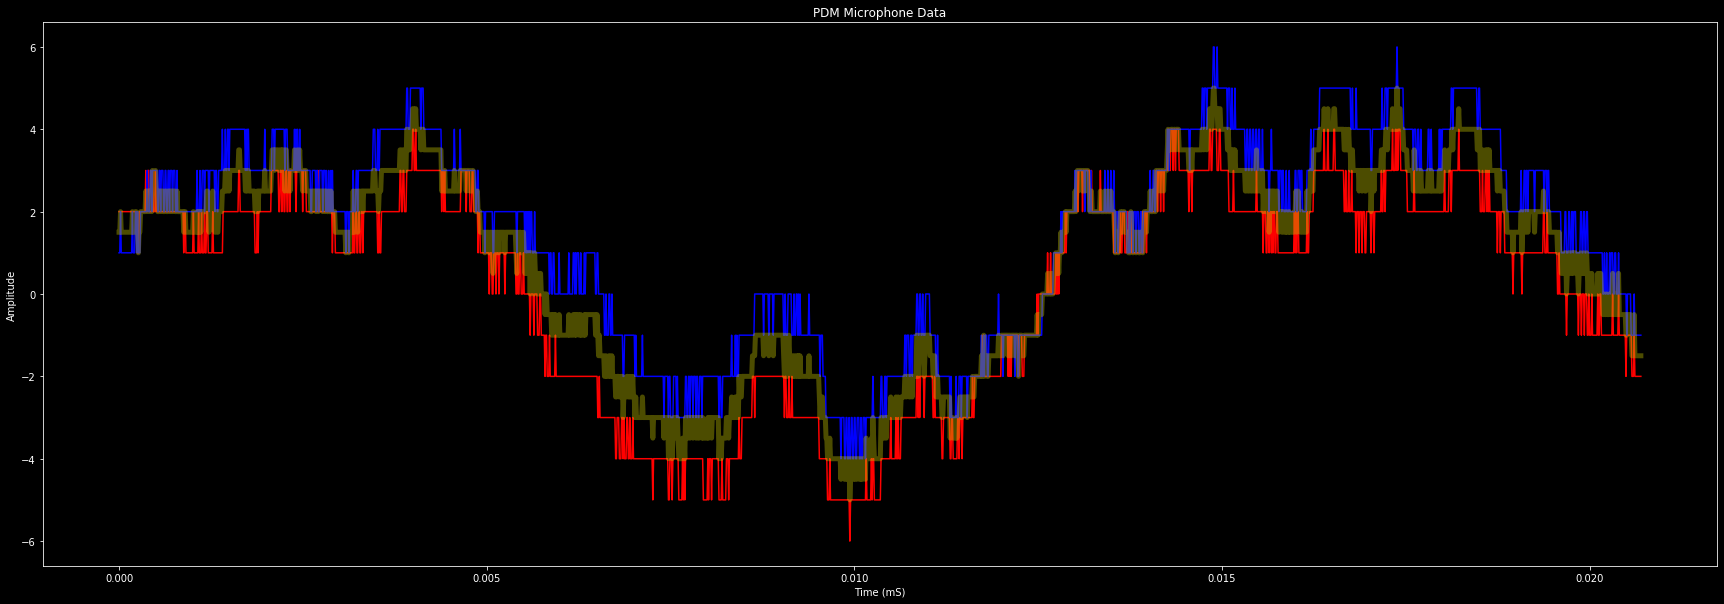

In [159]:
fsamp = (19e6 / (32*6))
samp = 2048
larr = np.zeros(samp)
rarr = np.zeros(samp)
n = np.linspace(0, samp/fsamp, samp)
# 19MHz / (32 * 6) =

fig, ax = plt.subplots()
ax.set_xlabel("Time (mS)")
ax.set_ylabel("Amplitude")
ax.set_title("PDM Microphone Data")
    
larr_raw = []
rarr_raw = []
s.flushInput()
play_audio(np.real(sn))
s.write(b"r")
res = s.readline().decode().strip()
if res == "left:":
    larr_raw = s.readline().decode().strip().split(" ") # tprint(larr_raw)
else:
    # todo: throw error / warning
    tprint("not left!")
res = s.readline().decode().strip()
if res == "right:":
    rarr_raw = s.readline().decode().strip().split(" ") # tprint(rarr_raw)
else:
    tprint("not right!")

larr = np.array(list(map(int, larr_raw)))
rarr = np.array(list(map(int, rarr_raw)))
tarr = (larr + rarr) / 2.0

ax.plot(n, larr, 'r-')
ax.plot(n, rarr, 'b-') 
ax.plot(n, tarr, 'y-', alpha=0.4, linewidth=5)
plt.show()

And, whenever needed, run the below cell to clean and close the Serial Port.

In [14]:
s.flushInput()
s.flushOutput()
s.close()

C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Will\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Time (s)')

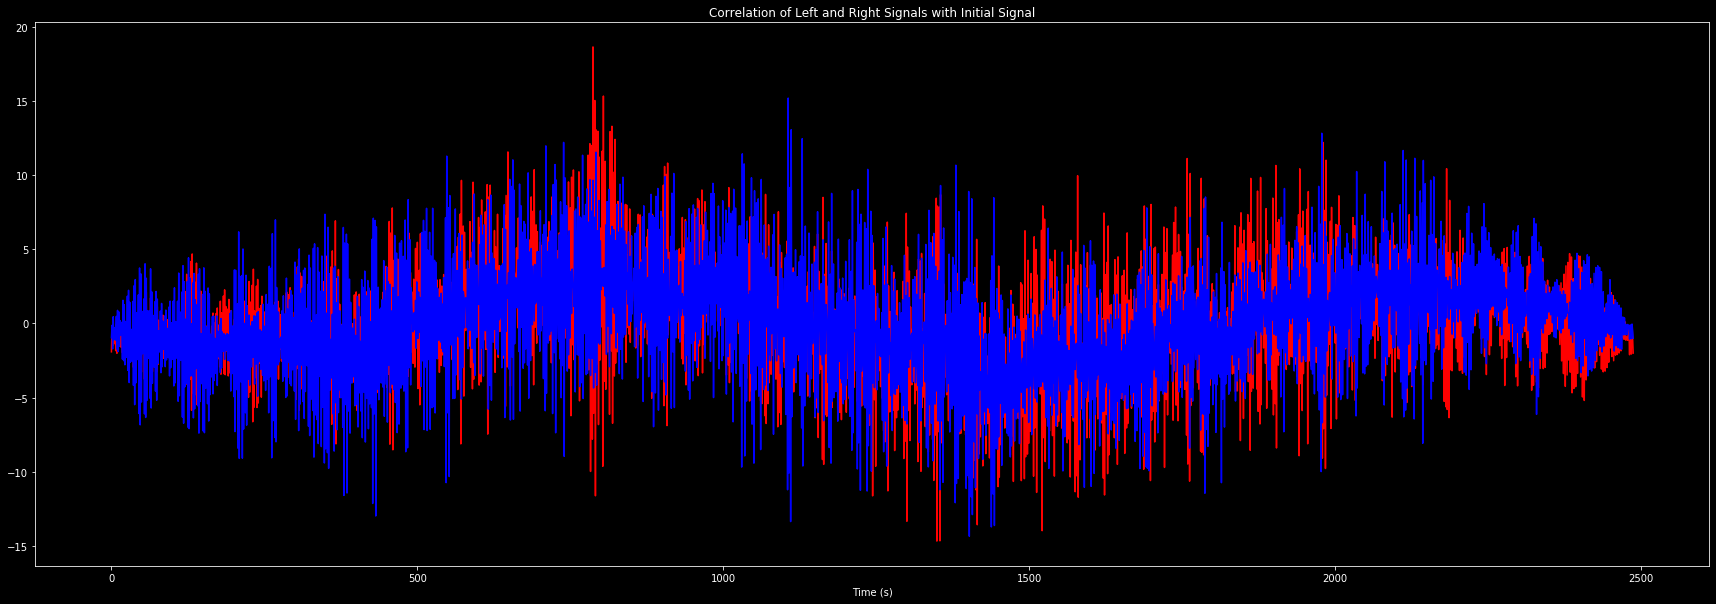

In [160]:
S_nL = sc.fft.fft(larr) #frequency domain
S_nR = sc.fft.fft(rarr)
time_iS_nL = sc.fft.ifft(S_nL)
time_iS_nR = sc.fft.ifft(S_nR)
#print(time_iS_nL.shape)
TIME_correlationL = np.correlate(time_iS_nL,sn,"full")
TIME_correlationR = np.correlate(time_iS_nR,sn,"full")
#print(TIME_autocorrelation.shape)
#print(BUFFER_SIZE/samplef)
n = np.linspace(0, samp/fsamp, len(larr))
plt.plot(TIME_correlationL, "r-")
plt.plot(TIME_correlationR, "b-")
plt.title("Correlation of Left and Right Signals with Initial Signal")
plt.xlabel("Time (s)")